# Predicción de ventas de videojuegos
_Ventas de videojuegos de Vgchartz y calificaciones correspondientes de Metacritic_

![Portada_juegos](https://storage.googleapis.com/kaggle-datasets-images/576/1101/b0b16198fac737f0da4b8be43bac64f3/dataset-cover.jpg)

# 0.- Importación de librerias + Funciones reutilizables

In [230]:
import pandas as pd # Manejo de data estructurada (Dataframe)
import numpy as np #Manejo de matrices
import matplotlib.pyplot as plt # Gráficas
import seaborn as sns  #Gráficas sencillas

# Separar datos en Train(Entrenamiento) y Test(Prueba)
from sklearn.model_selection import train_test_split 
seed=2020 # Una semilla se usa para que el modelo sea replicable

# Nube de Palabras
from wordcloud import WordCloud, STOPWORDS 

## Configuración de los parámetros de visualización

In [231]:
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

# Set default font size and facecolor
plt.rcParams["font.size"] = 24
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize
figsize(15, 12)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


## Funciones

In [232]:
def analizadorNulos(data):
    
    qFilas, qColumnas = data.shape
    if data.isnull().any().any():
        view_info = pd.DataFrame(pd.concat([data.isnull().any(), data.isnull().sum(), 
                                            round(data.isnull().sum() / qFilas * 100, 2), data.dtypes], axis=1))
        view_info.columns = ['Nulos', 'Cantidad', '%_Nulos', 'Tipo_Dato']
        view_info.sort_values(by='%_Nulos', ascending = False, inplace = True)
        display(view_info[view_info['Cantidad'] > 0])
        #Graficando el porcentaje de nulos
        plt.figure(figsize=(10,7))
        plt.title('Porcentaje de Nulos', fontsize = 15)
        plt.grid(True)
        plt.yticks(range(qColumnas + 1, 1 , -1), view_info.index, fontsize=20)
        plt.xlabel("Porcentaje de Nulos",fontsize=15)
        plt.ylabel("Variables\n",fontsize=20)
        #plt.xlim(0,100)
        plt.barh(range(qColumnas + 1, 1 , -1), width=view_info['%_Nulos'],height=0.5)
        #print(list(enumerate(view_info['%_Nulos'], 1)))
        for i, txt in enumerate(view_info['%_Nulos']):
          plt.annotate(str(txt) + '%', (txt, (qColumnas + 1 - i) ), fontsize = 12)
    else:
        print("No existen Nulos")

In [233]:
def remover_outliers(df, list_of_keys):
    df_out = df
    for key in list_of_keys:
        # Calculate first and third quartile
        first_quartile = df_out[key].describe()["25%"]
        third_quartile = df_out[key].describe()["75%"]

        # Interquartile range
        iqr = third_quartile - first_quartile

        # Remove outliers
        removed = df_out[(df_out[key] <= (first_quartile - 3 * iqr)) |
                    (df_out[key] >= (third_quartile + 3 * iqr))] 
        df_out = df_out[(df_out[key] > (first_quartile - 3 * iqr)) &
                    (df_out[key] < (third_quartile + 3 * iqr))]
    return df_out, removed

# 1.- Comprensión del Negocio

**Ventas de videojuegos de Vgchartz y calificaciones correspondientes de Metacritic**

Motivado por el web scraping de [Gregory Smith](https://www.kaggle.com/gregorut/datasets) de VGChartz [‎‎Video Games Sales](https://www.kaggle.com/gregorut/videogamesales).
Este conjunto de datos simplemente amplía el número de variables con otro web scraping de [‎‎Metacritic](https://www.metacritic.com/browse/games/release-date/available).‎‎

Desafortunadamente, faltan observaciones, ya que Metacritic solo cubre un subconjunto de las plataformas. Además, un juego puede no tener todas las observaciones de las variables adicionales que se analizan a continuación. 
Los casos completos son ~ 6,900‎

# 2.- Comprensión de los datos

Este [dataset](https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings) se encuentra en Kaggle. Este contiene 16 variables que se detallaran a continuación:
 

| Variable | Descripción                                                                     |
|:-----------------|:----------------------------------------------------------------------------------|
| Name            | Nombre del juego                                                                 |
| Platform        | Consola en la que se ejecuta el juego                                            |
| Year_of_Release | Año de lanzamiento                                                               |
| Genre           | Genero del juego              |
| Publisher       | Estudio                                                                           |
| NA_Sales        | Ventas de juegos en América del Norte                  |
| EU_Sales        | Ventas de juegos  en la Unión Europea                        |
| JP_Sales        | Ventas de juegos  en Japón                         |
| Other_Sales     | Ventas de juegos en el resto del mundo, es decir, África, Asia excluyendo Japón, Australia, Europa excluyendo la UE.                        |
| Global_Sales    | Ventas totales en el mundo (en millones de unidades)                             |
| Critic_Score    | Puntuación de la critica - max 100                    |
| Critic_Count    | El número de críticos utilizados en la elaboración de la puntuación de la crítica |
| User_Score      | Puntuación de los usuarios     - - max 100                                  |
| User_Count      | número de usuarios que dieron la puntuación de usuario                            |
| Developer       | Parte responsable de crear el juego                                              |
| Rating          | Las calificaciones de la ESRB                                                    |

## 2.1.- Recopilación de los Datos

In [234]:
url = "https://raw.githubusercontent.com/MayumyCH/video_game_sales_with_ratings/main/dataset/videoGames_Sales.csv"
dataGames = pd.read_csv(url, index_col=False)
dataGames.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [235]:
dataGames.shape
# INTERPRETACION:
# 16719 observaciones | registros | filas
# 16 variables | features  | columnas

(16719, 16)

In [236]:
dataGames.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count', 'Developer', 'Rating'],
      dtype='object')

In [237]:
# Renombrando la columna Year_of_Release por Year para facil uso
dataGames = dataGames.rename(columns={"Year_of_Release": "Year"})

## 2.2.- Analizando las variables del dataset

In [238]:
dataGames.info()
# 7 Features de tipo object (Name, Platform, Genre, Publisher, User_Score, Developer, Rating)
# 9 Features numericos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          16717 non-null  object 
 1   Platform      16719 non-null  object 
 2   Year          16450 non-null  float64
 3   Genre         16717 non-null  object 
 4   Publisher     16665 non-null  object 
 5   NA_Sales      16719 non-null  float64
 6   EU_Sales      16719 non-null  float64
 7   JP_Sales      16719 non-null  float64
 8   Other_Sales   16719 non-null  float64
 9   Global_Sales  16719 non-null  float64
 10  Critic_Score  8137 non-null   float64
 11  Critic_Count  8137 non-null   float64
 12  User_Score    10015 non-null  object 
 13  User_Count    7590 non-null   float64
 14  Developer     10096 non-null  object 
 15  Rating        9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


In [239]:
# OBSERVACION
# 1.- User_Score Convertirlo en variable numerica como "Critic_Score"
# 2.- Hay muchas variables que tienen valores nulos

,Nulos,Cantidad,%_Nulos,Tipo_Dato
User_Count,True,9129,54.60,float64
Critic_Score,True,8582,51.33,float64
Critic_Count,True,8582,51.33,float64
Rating,True,6769,40.49,object
User_Score,True,6704,40.10,object
Developer,True,6623,39.61,object
Year,True,269,1.61,float64
Publisher,True,54,0.32,object
Name,True,2,0.01,object
Genre,True,2,0.01,object


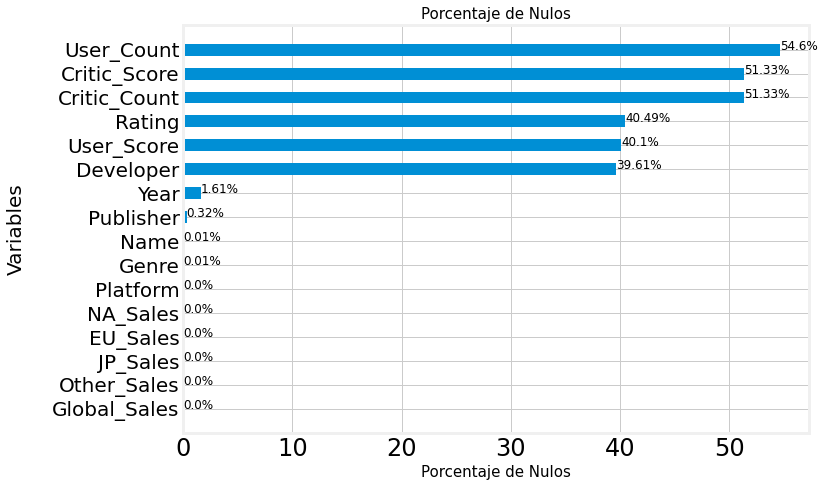

In [240]:
analizadorNulos(dataGames)

**User_Score Convertirlo en variable numerica como "Critic_Score"**

In [241]:
dataGames["User_Score"].describe()

count     10015
unique    96   
top       tbd  
freq      2425 
Name: User_Score, dtype: object

In [242]:
# Reemplazo de valores "tbd" con np.nan y transformación de columna a tipo flotante
dataGames["User_Score"] = dataGames["User_Score"].replace("tbd", np.nan).astype(float)
dataGames["User_Score"].dtypes

dtype('float64')

**Creando una variable para indicar si tiene al menos algun score ya sea de usuario o critico**

In [243]:
# dataGames["Has_Score"] = dataGames["User_Score"].notnull() & dataGames["Critic_Score"].notnull()
dataGames["Has_Score"] = dataGames["User_Score"].notnull() | dataGames["Critic_Score"].notnull()

In [244]:
dataGames.shape

(16719, 17)

In [245]:
# Veamos la cantidad de datos que se tiene por GENERO
print(" TABLA DE CANTIDAD DE DATOS C/S SCORE POR GENERO")
print(" ------------------")
tb_Genre_Score = pd.crosstab(index = dataGames['Has_Score'],
                          columns = [dataGames['Genre']],
                          margins=True)
tb_Genre_Score.index = ['Sin Score', 'Con Score','Total']
# tb_Genre_Score.columns = ["1","2","3, 'Total']
display(tb_Genre_Score)
print(" \n")

 TABLA DE CANTIDAD DE DATOS C/S SCORE POR GENERO
 ------------------


Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy,All
Sin Score,1327,945,424,1184,370,349,464,741,341,484,1024,354,8007
Con Score,2043,358,425,566,518,231,785,759,982,390,1324,329,8710
Total,3370,1303,849,1750,888,580,1249,1500,1323,874,2348,683,16717


## 2.3.- Analizando las variables del dataset para el genero "Accion"

In [246]:
df_action = dataGames[dataGames['Genre']=='Action']
df_action.shape

(3370, 17)

In [247]:
# VARIABLE A PREDECIR "Global_Sales"

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0.98, 'Variable "Global_Sales"')

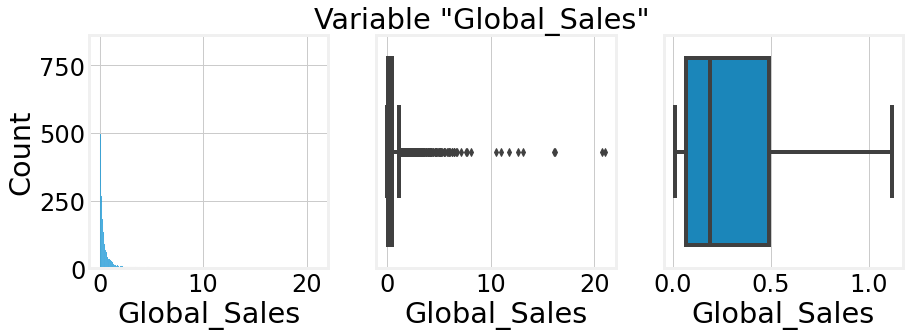

In [248]:
GSalesfig, axs = plt.subplots(ncols = 3, figsize=(13, 4))

sns.histplot(df_action.Global_Sales.dropna(), ax=axs[0])
sns.boxplot(df_action.Global_Sales, ax=axs[1])
sns.boxplot(df_action.Global_Sales, ax=axs[2], showfliers=False)

GSalesfig.suptitle('Variable "Global_Sales"')

In [249]:
# OBSERVACION
# Se observa valores outlier en nuestra variable de ventas generales

# TOPEAR LOS VALORES MAYORES DE LOS VALORES SALES
df_action.loc[df_action['Global_Sales'] >= 8,'Global_Sales'] = 8

,Nulos,Cantidad,%_Nulos,Tipo_Dato
User_Count,True,1540,45.70,float64
User_Score,True,1540,45.70,float64
Critic_Score,True,1480,43.92,float64
Critic_Count,True,1480,43.92,float64
Rating,True,1182,35.07,object
Developer,True,1144,33.95,object
Year,True,62,1.84,float64
Publisher,True,6,0.18,object


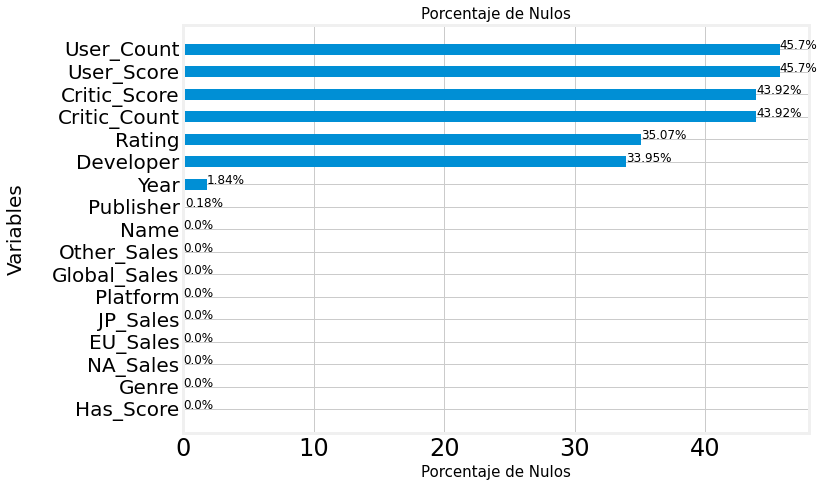

In [250]:
analizadorNulos(df_action)

In [251]:
# DATOS CON SCORE
df_actionScore = df_action[df_action["Has_Score"]]
df_actionNotScore = df_action[~df_action["Has_Score"]]
df_actionScore.shape , df_actionNotScore.shape

((2043, 17), (1327, 17))

In [252]:
df_actionScore.describe()

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,2003.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,1890.000000,1890.000000,1830.000000,1830.000000
mean,2008.428857,0.325174,0.209104,0.039310,0.078483,0.624209,66.629101,27.780952,7.054044,188.889617
std,4.255255,0.648005,0.486582,0.132171,0.298021,1.066626,14.206877,20.301921,1.425394,542.538499
min,1996.000000,0.000000,0.000000,0.000000,0.000000,0.010000,19.000000,4.000000,0.300000,4.000000
25%,2005.000000,0.050000,0.020000,0.000000,0.010000,0.100000,57.000000,12.000000,6.300000,11.000000
50%,2008.000000,0.130000,0.060000,0.000000,0.020000,0.260000,68.000000,22.000000,7.400000,28.000000
75%,2012.000000,0.330000,0.200000,0.010000,0.070000,0.635000,77.000000,39.000000,8.100000,103.500000
max,2016.000000,9.660000,9.090000,2.020000,10.570000,8.000000,98.000000,106.000000,9.500000,8003.000000


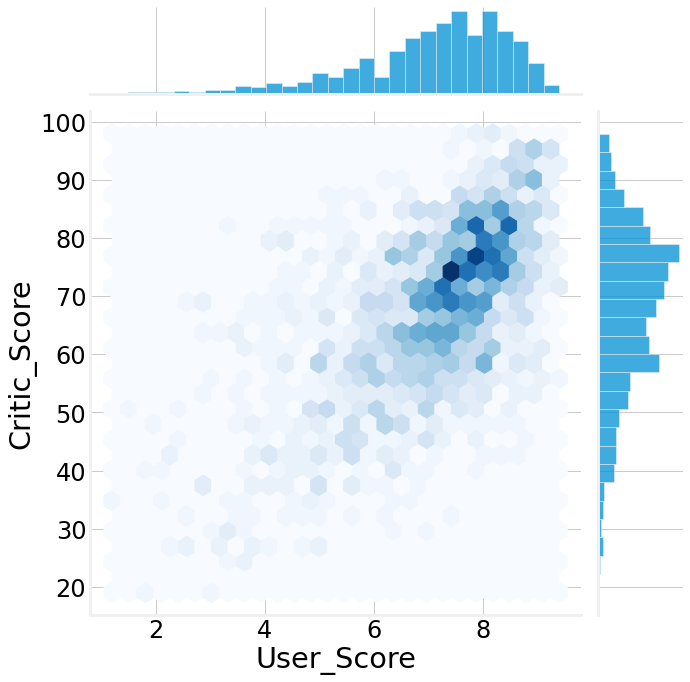

In [253]:
g = sns.jointplot(data=df_actionScore, x="User_Score", y="Critic_Score",cmap="Blues", kind="hex",height=10)

In [254]:
# OBSERVACION
# 1.-  La mayoría de los juegos tienen una puntuación bastante buena
# 2.-  La cantidad de juegos que fueron calificados por los User en mas de  7+ 
#      fueron calificados en +70 por los critic score

,Nulos,Cantidad,%_Nulos,Tipo_Dato
User_Count,True,213,10.43,float64
User_Score,True,213,10.43,float64
Critic_Count,True,153,7.49,float64
Critic_Score,True,153,7.49,float64
Year,True,40,1.96,float64
Rating,True,21,1.03,object
Developer,True,3,0.15,object


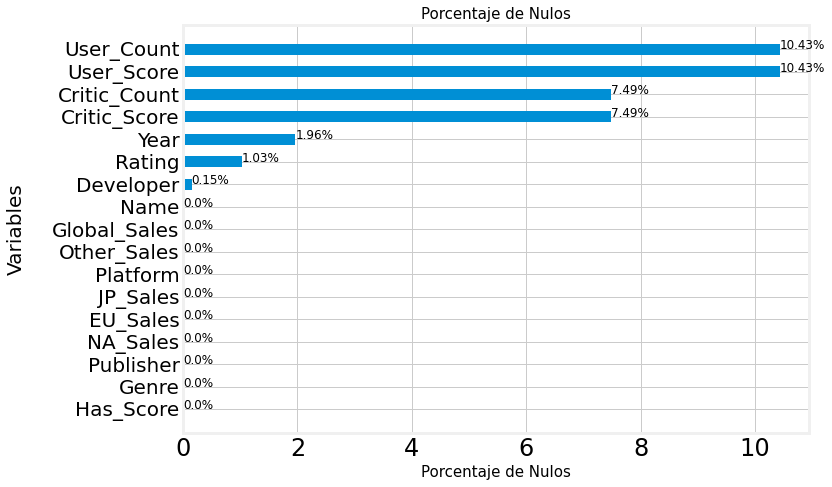

In [255]:
analizadorNulos(df_actionScore)

In [256]:
# OBSERVACION
# 1.- La variable años como representa el 1.96% lo procederemos a eliminar
# 2.- Hay que llenar los 4 features con la media de cada feature
# 3.- La variable Rating y Developer se representara por la moda

1.- La variable años como representa el 1.96% lo procederemos a eliminar


In [257]:
df_actionScore['Year'].isnull().sum()

40

In [258]:
# df_actionScore.dropna(subset=['Year'], inplace=True)
df_actionScore = df_actionScore[df_actionScore["Year"].notnull()]

# Convertir mi variable Year en numerico ya que era tipo Object
df_actionScore["Year"] = df_actionScore["Year"].apply(int)

2.- Hay que llenar los 4 features con la media de cada feature

3.- La variable Rating y Developer se representara por la moda

In [259]:
df_actionScore['Critic_Score'].fillna(df_actionScore['Critic_Score'].median(), inplace=True)
df_actionScore['Critic_Count'].fillna(df_actionScore['Critic_Count'].median(), inplace=True)
df_actionScore['User_Score'].fillna(df_actionScore['User_Score'].median(), inplace=True)
df_actionScore['User_Count'].fillna(df_actionScore['User_Count'].median(), inplace=True)

df_actionScore['Rating'].fillna(df_actionScore['Rating'].mode()[0], inplace=True)
df_actionScore['Developer'].fillna(df_actionScore['Developer'].mode()[0], inplace=True)

In [260]:
analizadorNulos(df_actionScore)

No existen Nulos


In [261]:
# Cantidad de juegos en general vs juego de gnre Accion

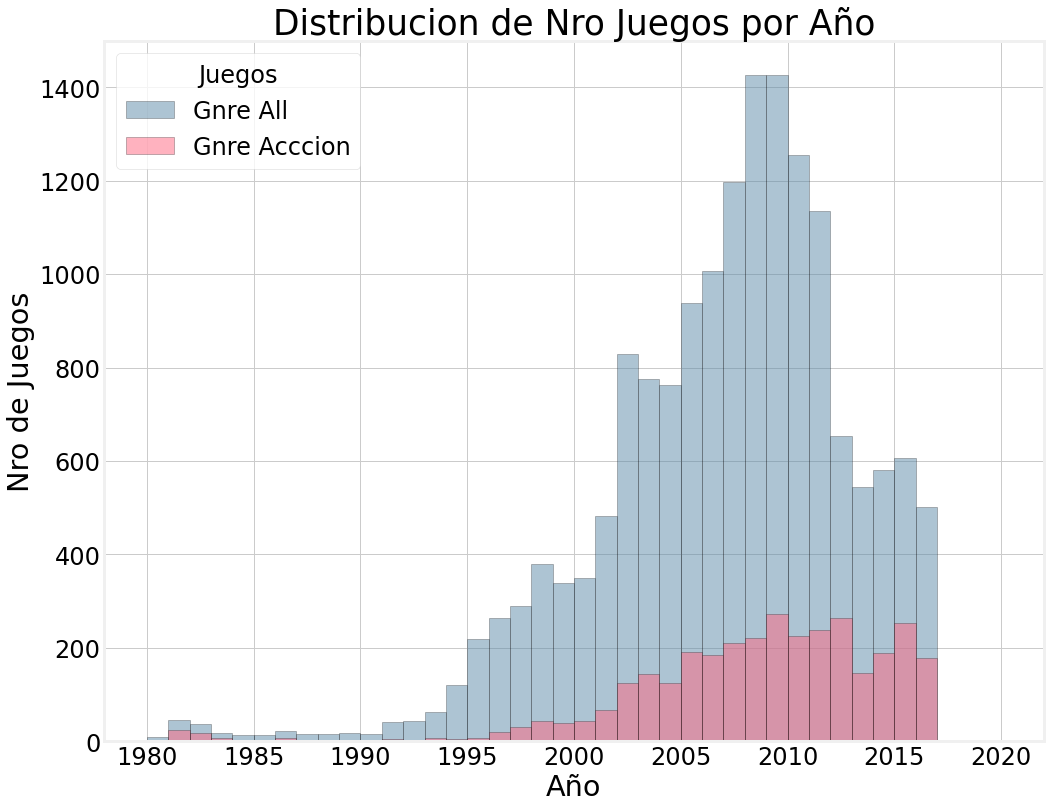

In [262]:
# Histograma de la cantidad de juegos de todos los generos vs los juegos del genero de Accion
num_years = df_action["Year"].max() - df_action["Year"].min() + 1
plt.hist(dataGames["Year"], bins=range(1980, 2021), color="#5D8AA8", edgecolor="black", alpha=0.5)
plt.hist(df_action["Year"], bins=range(1980, 2021), color="#FF6680", edgecolor="black", alpha=0.5)

plt.title("Distribucion de Nro Juegos por Año")
plt.xlabel("Año")
plt.ylabel("Nro de Juegos");

plt.legend(["Gnre All", "Gnre Acccion"],loc="upper left",title="Juegos");

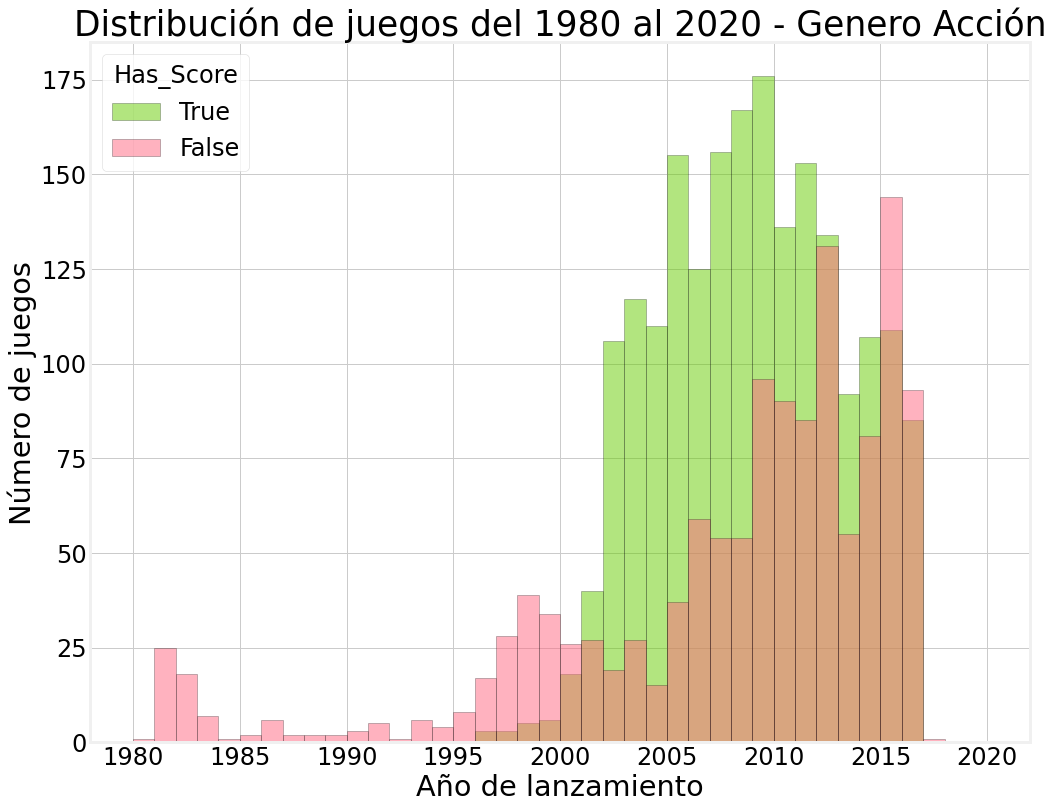

In [263]:
# CANTIDAD DE JUEGOS POR AÑO
from matplotlib.lines import Line2D
plt.hist(df_action[df_action["Has_Score"]==True]["Year"], color="#66CC00", alpha=0.5, 
         bins=range(1980, 2021), edgecolor="black")
plt.hist(df_action[df_action["Has_Score"]==False]["Year"], color="#FF6680", alpha=0.5, 
         bins=range(1980, 2021), edgecolor="black")
plt.title("Distribución de juegos del 1980 al 2020 - Genero Acción");
plt.xlabel("Año de lanzamiento")
plt.ylabel("Número de juegos")
plt.legend(["True", "False"],loc="upper left",title="Has_Score");

In [264]:
# OBSERVACION
# 1.- Del 1980 al 1995 aprox no habia alguna empresa o plataforma que calificaba los juegos
# 2.- Desde el 1995 se empezaron a calificar los juegos
# 3.- Los juegos con score se distribuyen de manera más uniforme entre 2000 y 2015
# 4.- Hay un pico en 2015 para los juegos sin puntaje.
#     Posiblemente salieron muchos juegos y quizas algunos de ellos pasaron desapercibidos 
# 5.- En el rango 1995-2000 número total de juegos fue creciendo significativamente pero no todos eran calificados
#     En esos años recien se ha creado plataforma dedicada (como Steam) o una revista especializada para revisar juegos.

In [265]:
# OBSERVACION
# 1.- Del 1980 al 
# Los juegos sin puntuación tienden a tener menos ventas globales.
# Quiero ver en qué región los juegos fueron más populares, según las ventas.

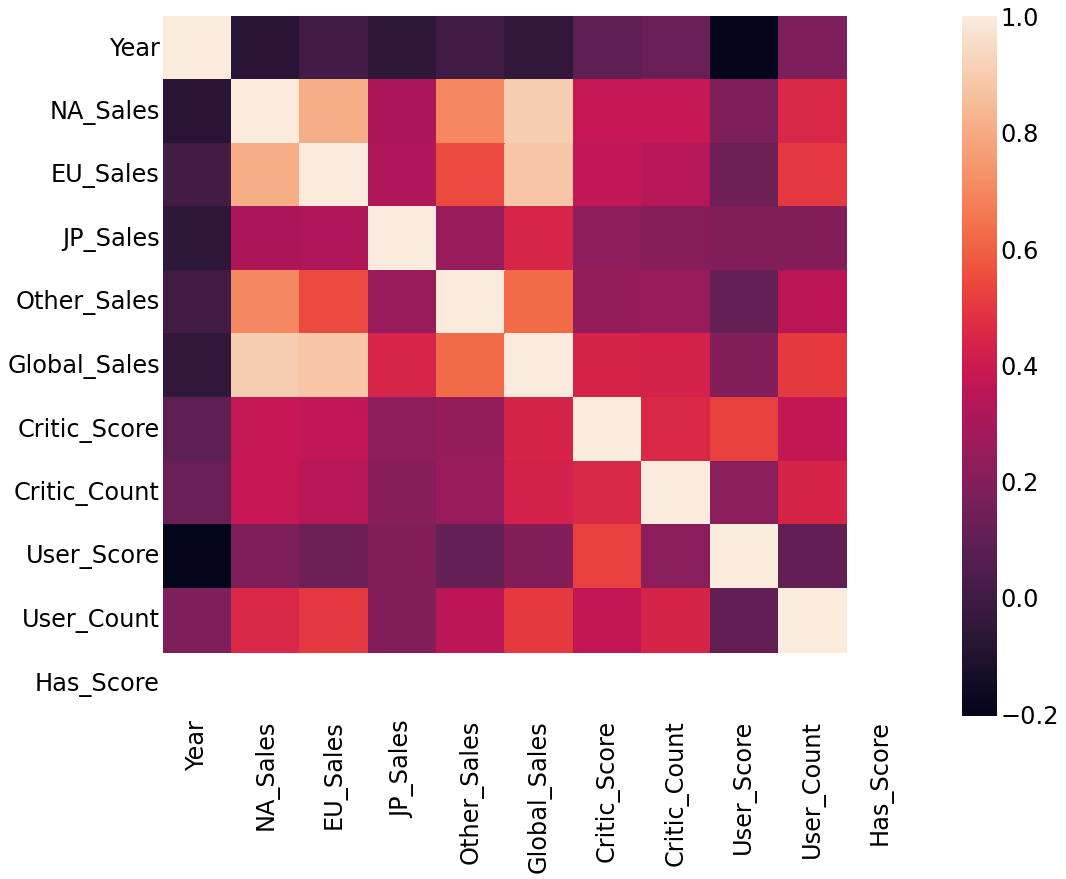

In [266]:
# ANALIZAR LA CORRELACION DE MIS VARIABLES NUMERICAS
sns.heatmap(df_actionScore.corr())

In [267]:
df_actionScore.corr()['Global_Sales'].sort_values()

Year           -0.045150
User_Score      0.196443
Critic_Count    0.429609
Critic_Score    0.436868
JP_Sales        0.441947
User_Count      0.503288
Other_Sales     0.627949
EU_Sales        0.883294
NA_Sales        0.905475
Global_Sales    1.000000
Has_Score      NaN      
Name: Global_Sales, dtype: float64

In [268]:
# OBSERVACION
# Como las variables que estan mas correlacionadas son: NA_Sales y EU_Sales
# pero ambas estan muy correlacionadas entre ellas por ello es que escogere solo una de ellas          

In [269]:
# Describir nuestros datos
# data.describe(include="all")
df_actionScore.describe()

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000
mean,2008.428857,0.325681,0.209471,0.039775,0.078937,0.625452,66.777334,27.520719,7.093460,172.149775
std,4.255255,0.652358,0.490606,0.132717,0.300807,1.073669,13.620933,19.606288,1.352292,514.659819
min,1996.000000,0.000000,0.000000,0.000000,0.000000,0.010000,19.000000,4.000000,0.300000,4.000000
25%,2005.000000,0.050000,0.020000,0.000000,0.010000,0.100000,58.000000,13.000000,6.500000,13.000000
50%,2008.000000,0.130000,0.060000,0.000000,0.020000,0.260000,68.000000,23.000000,7.400000,28.000000
75%,2012.000000,0.320000,0.200000,0.010000,0.070000,0.630000,76.000000,37.000000,8.000000,82.000000
max,2016.000000,9.660000,9.090000,2.020000,10.570000,8.000000,98.000000,106.000000,9.500000,8003.000000


VARIABLES CATEGORICAS

In [270]:
df_actionScore["Platform"].unique(), df_actionScore["Rating"].unique()

(array(['PS3', 'PS2', 'X360', 'PS4', 'PSP', 'Wii', 'PS', 'XOne', 'DS',
        'GC', '3DS', 'XB', 'GBA', 'PC', 'PSV', 'WiiU'], dtype=object),
 array(['M', 'E', 'T', 'E10+', 'AO'], dtype=object))

In [271]:
# OBSERVACION
# Hay 16 plataformas únicas, 5 calificaciones en los datos restantes.
# Para trabajar con la variable Platform vamos a agruparlo

In [272]:
def get_group_label(x, groups=None):
    if groups is None:
        return "Other"
    else:
        for key, val in groups.items():
            if x in val:
                return key
        return "Other"

In [273]:
# AGRUPAR LAS PLATAFORMAS
dic_platforms = {"Playstation" : ["PS", "PS2", "PS3", "PS4"],
             "Xbox" : ["XB", "X360", "XOne"], 
             "PC" : ["PC"],
             "Nintendo" : ["Wii", "WiiU"],
             "Portable" : ["GB", "GBA", "GC", "DS", "3DS", "PSP", "PSV"]}

In [274]:
df_actionScore["GPlatforms"] = df_actionScore["Platform"].apply(lambda x: get_group_label(x, groups=dic_platforms))     

In [275]:
df_actionScore["GPlatforms"].unique()

array(['Playstation', 'Xbox', 'Portable', 'Nintendo', 'PC'], dtype=object)

In [276]:
# ANALIS DE LOS NOMBRES DE LOS JUEGOS

In [277]:
df_actionScore.Name

16       Grand Theft Auto V               
17       Grand Theft Auto: San Andreas    
23       Grand Theft Auto V               
24       Grand Theft Auto: Vice City      
38       Grand Theft Auto III             
                 ...                      
16658    Ben 10 Omniverse 2               
16664    Prison Architect                 
16667    E.T. The Extra-Terrestrial       
16696    Metal Gear Solid V: Ground Zeroes
16699    Planet Monsters                  
Name: Name, Length: 2003, dtype: object

In [278]:
def show_wordcloud(dataWords):
  # Veamos los nombres de nuestros juegos
  comment_words = '' 
  stopwords = set(STOPWORDS)

  # Haciendo cada celda de la columna Motivation una lista, sin comillas y
  #  agregandola a una variable con todas las palabras

  for word in dataWords:
      word = str(word)
      msg = word.replace('"', ' ').strip().split()
      comment_words += " ".join(msg)+" "


  # Instanciando el wordCloud
  wordcloud = WordCloud(width = 500, height = 500, 
                  background_color ='white', 
                  stopwords = stopwords, 
                  min_font_size = 10).generate(comment_words)


  # WORDCLOUD DE TODOS LOS MENSAJES EN GENERAL                 
  plt.figure(figsize = (4, 10), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  plt.show()

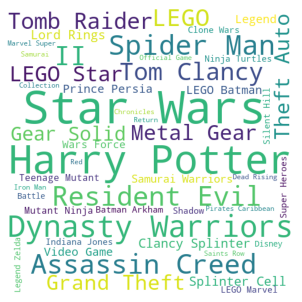

In [279]:
# Names de los juegos que si fueron evaluados
dataWords = df_actionScore.Name
show_wordcloud(dataWords)

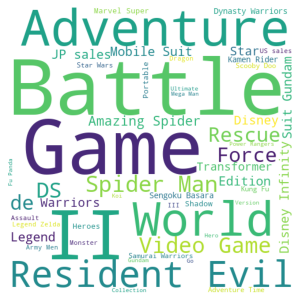

In [280]:
# Nombre de los juegos que no fueron calificados
dataWords = df_actionNotScore.Name
show_wordcloud(dataWords)

In [281]:
# df_actionScore.describe(include = 'object').T
df_actionScore.describe(include = 'object')

,Name,Platform,Genre,Publisher,Developer,Rating,GPlatforms
count,2003,2003,2003,2003,2003,2003,2003
unique,1010,16,1,122,525,5,5
top,LEGO Jurassic World,X360,Action,Activision,Omega Force,T,Playstation
freq,8,268,2003,209,73,671,648


# 3.- Modelo

In [282]:
# df_actionScore.select_dtypes("number")

## Prepocesnando los datos categoricos

In [283]:
# VARIABLE NUMERICA
df_num = df_actionScore.select_dtypes("number").drop(columns=["Year","Other_Sales","JP_Sales", "EU_Sales"])

# VARIABLE CATEGORICA
df_cat = df_actionScore[["GPlatforms", "Rating"]]

df_cat = pd.get_dummies(df_cat, drop_first=True)

In [284]:
dataModel = pd.concat([df_num, df_cat], axis = 1)
X = dataModel.drop(columns="Global_Sales")
y = dataModel["Global_Sales"]

In [285]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=seed)  #Semilla para replicar el modelo 

In [286]:
#Revisamos los tamaños de las pruebas de train y test
print("Tamaño del conjunto de datos Inicial:", dataModel.shape)
print("Tamaño del conjunto de características del entrenamiento:",X_train.shape)
print("Tamaño del conjunto de características de prueba:",X_test.shape)
print("Tamaño de la variable objetivo del entrenamiento:",y_train.shape)
print("Tamaño de la variable objetivo de prueba:",y_test.shape)

Tamaño del conjunto de datos Inicial: (2003, 14)
Tamaño del conjunto de características del entrenamiento: (1402, 13)
Tamaño del conjunto de características de prueba: (601, 13)
Tamaño de la variable objetivo del entrenamiento: (1402,)
Tamaño de la variable objetivo de prueba: (601,)


In [287]:
# IMPORTANDO LOS DIFERENTES MODELOS DE REGRESION
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [288]:
def mae(y_true, y_pred):
    return np.average(abs(y_true - y_pred))

In [289]:
def fit_and_evaluate(model):
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Predecir y evaluar
    model_pred = model.predict(X_train)
    model_mae = mae(y_train, model_pred)
    
    # Return the performance metric
    return model_mae

In [290]:
# MODELO DUMMY
baseline_guess = np.median(X_train)
basic_baseline_mae = mae(y_train, baseline_guess)

In [291]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)
print("Linear Regression Performance on the test set: MAE = {:.04f}".format(lr_mae))

Linear Regression Performance on the test set: MAE = 0.2079


In [292]:
svm = SVR(C = 1000, gamma=0.1)
svm_mae = fit_and_evaluate(svm)

print("Support Vector Machine Regression Performance on the test set: MAE = {:.04f}".format(svm_mae))

Support Vector Machine Regression Performance on the test set: MAE = 0.0937


In [293]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print("Random Forest Regression Performance on the test set: MAE = {:.04f}".format(random_forest_mae))

Random Forest Regression Performance on the test set: MAE = 0.0604


In [294]:
gradient_boosting = GradientBoostingRegressor(random_state=60)
gradient_boosting_mae = fit_and_evaluate(gradient_boosting)

print("Gradient Boosting Regression Performance on the test set: MAE = {:.04f}".format(gradient_boosting_mae))

Gradient Boosting Regression Performance on the test set: MAE = 0.1076


In [295]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print("K-Nearest Neighbors Regression Performance on the test set: MAE = {:.04f}".format(knn_mae))

K-Nearest Neighbors Regression Performance on the test set: MAE = 0.4575


In [296]:
ridge = Ridge(alpha=10)
ridge_mae = fit_and_evaluate(ridge)

print("Ridge Regression Performance on the test set: MAE = {:.04f}".format(ridge_mae))

Ridge Regression Performance on the test set: MAE = 0.2112


In [ ]:
# MODELO DUMMY
baseline_guess = np.median(X_train)
basic_baseline_mae = mae(y_train, baseline_guess)

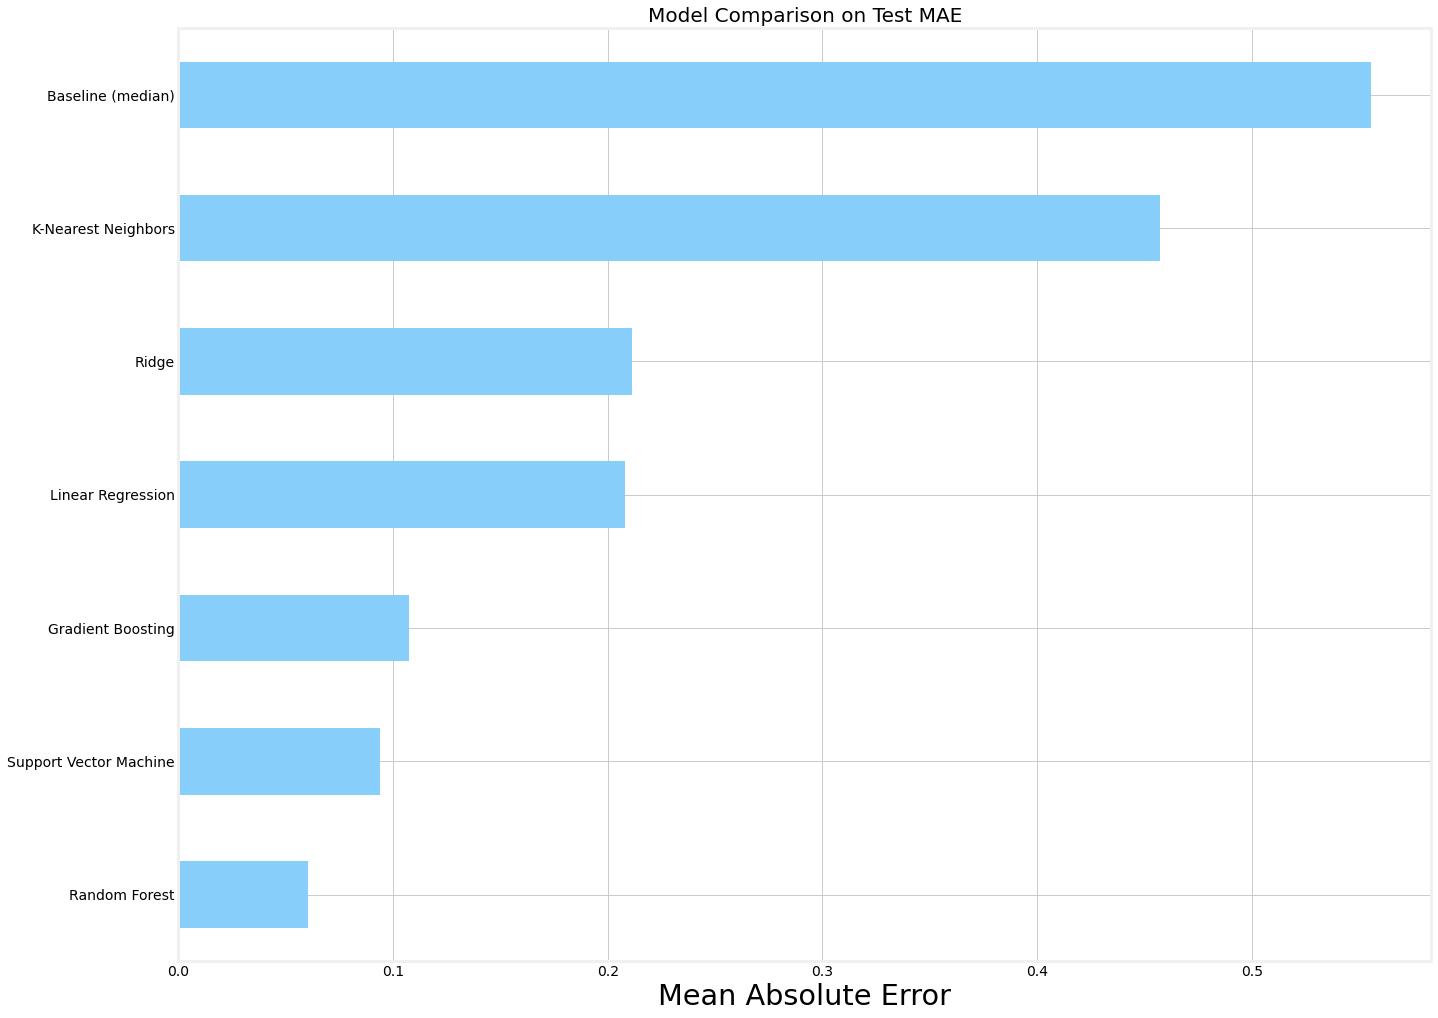

In [363]:
# COMPARAR LOS MODELOS
model_comparison = pd.DataFrame({"model": ["Linear Regression", "Support Vector Machine",
                                           "Random Forest", "Gradient Boosting",
                                            "K-Nearest Neighbors", "Baseline (median)", "Ridge"],
                                 "diff": ["-{:.2f}%".format((1 - lr_mae / basic_baseline_mae) * 100), 
                                          "-{:.2f}%".format((1 - svm_mae / basic_baseline_mae) * 100),
                                          "-{:.2f}%".format((1 - random_forest_mae / basic_baseline_mae) * 100),
                                          "-{:.2f}%".format((1 - gradient_boosting_mae / basic_baseline_mae) * 100),
                                          "-{:.2f}%".format((1 - knn_mae / basic_baseline_mae) * 100),
                                          "0.00%",
                                          "-{:.2f}%".format((1 - ridge_mae / basic_baseline_mae) * 100)
                                          ],
                                 "mae": [lr_mae, svm_mae, random_forest_mae, 
                                         gradient_boosting_mae, knn_mae, basic_baseline_mae, ridge_mae]})


model_comparison.sort_values("mae", ascending=True).plot(x="model", y="mae", kind="barh",
                                                           color="lightskyblue", legend=False)
plt.ylabel(""); plt.yticks(size=14); plt.xlabel("Mean Absolute Error"); plt.xticks(size=14)
plt.title("Model Comparison on Test MAE", size=20);

In [298]:
# Escogeremos el mejor modelo
# ---------------------------
from sklearn.linear_model import LinearRegression
from sklearn import metrics

lr = LinearRegression()
lr.fit(X_train, y_train)

train_pred=lr.predict(X_train)
test_pred=lr.predict(X_test)

lr_mae = fit_and_evaluate(lr)
lr_mae

0.2078774836106948

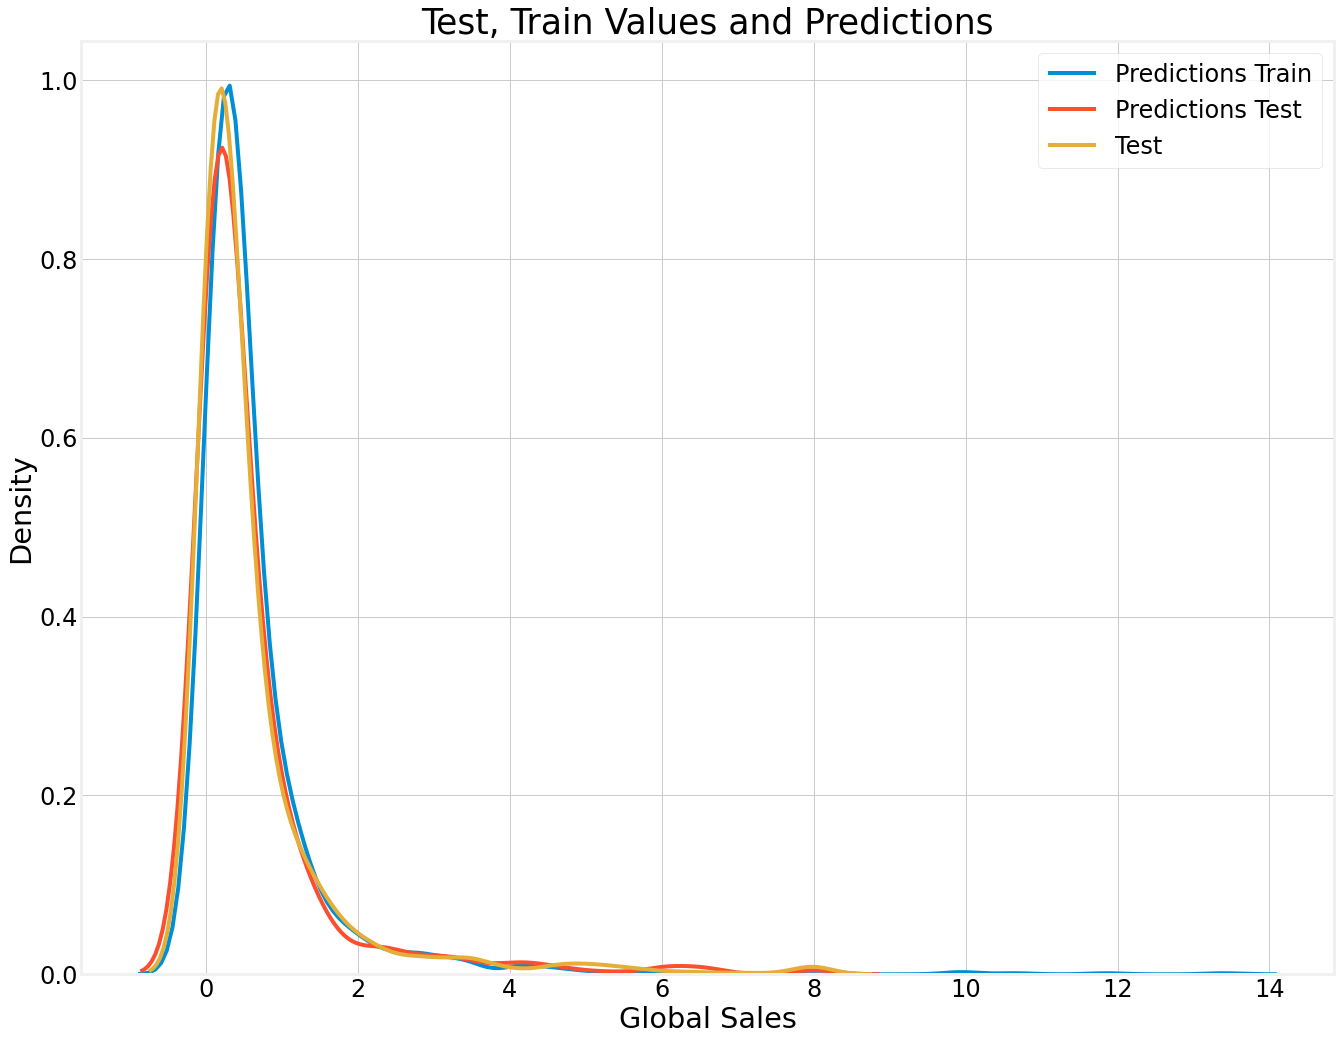

In [369]:
sns.kdeplot(train_pred, label = "Predictions")
# sns.kdeplot(test_pred, label = "Predictions")
sns.kdeplot(y_test, label = "Test")
sns.kdeplot(y_train, label = "Train")

plt.xlabel("Global Sales"); plt.ylabel("Density");
plt.title("Test, Train Values and Predictions");
plt.legend(["Predictions Train","Predictions Test", "Test", "Train"],loc="upper right");

In [364]:
# R2 || Ajuste del modelo := Que porcentaje de la variación de y es explicado por x
print("Valor del R cuadrado del train:", round(metrics.r2_score(y_train,train_pred), 2))
print("Valor del R cuadrado del test:", round(metrics.r2_score(y_test,test_pred), 2))

Valor del R cuadrado del train: 0.84
Valor del R cuadrado del test: 0.86


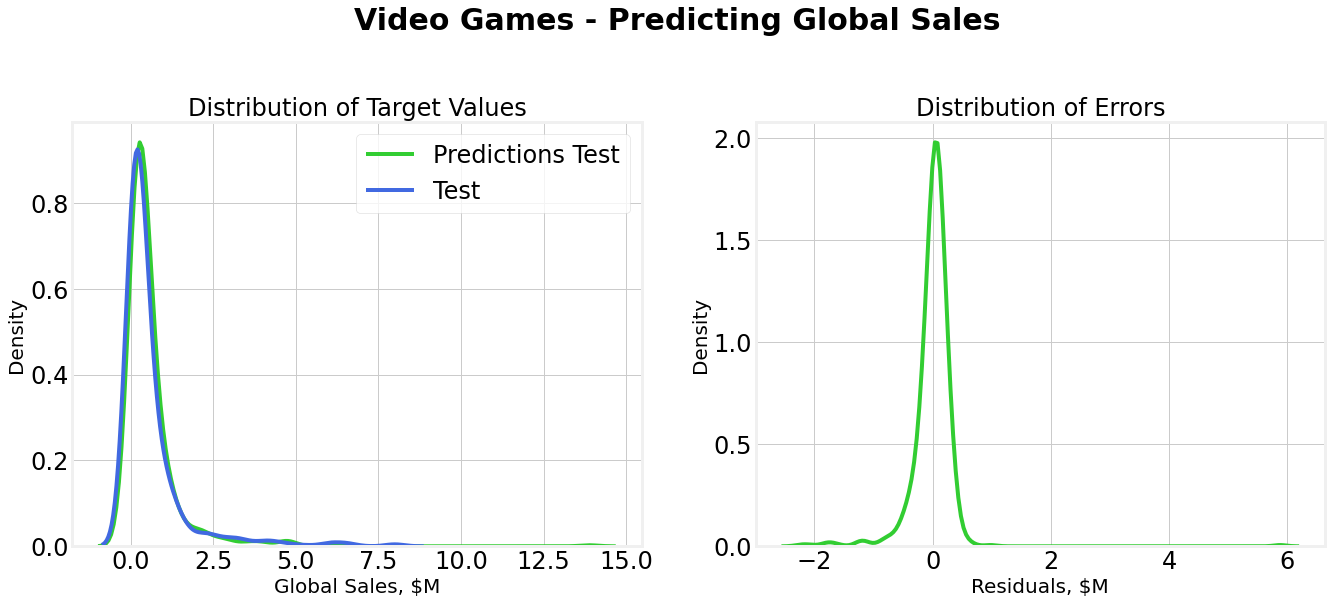

In [370]:
import matplotlib.gridspec as gridspec
figsize(20, 16)

fig = plt.figure()
gs = gridspec.GridSpec(2, 2)

plt.suptitle("Video Games - Predicting Global Sales", size=30, weight="bold");

ax = fig.add_subplot(gs[0, 0])
plt.sca(ax)
sns.kdeplot(test_pred, color="limegreen", label="Advanced Model")  # VALOR TEST PREDICHO
sns.kdeplot(y_test, color="royalblue", label="Test") # VALOR TEST REAL
plt.xlabel("Global Sales, $M", size=20); plt.ylabel("Density", size=20);
plt.title("Distribution of Target Values", size=24);
plt.legend(["Predictions Test", "Test"],loc="upper right");

residuals = test_pred - y_test
ax = fig.add_subplot(gs[0, 1])
plt.sca(ax)
sns.kdeplot(residuals, color = "limegreen", label="Advanced Model")
plt.xlabel("Residuals, $M", size=20);plt.ylabel("Density", size=20);
plt.title("Distribution of Errors", size=24);